# Logistic Regression(baseline)

Any player who has never competed in an NBA game prior to that year is considered a rookie in the league. The NBA presents the NBA Rookie of the Year Award to the top rookie at the conclusion of the regular season.A basketball player's transition to the NBA is a significant event. The beginning of their careers is something that sports analysts and fans eagerly anticipate to monitor and predict how they will perform in the future.This notebook will use Logistic Regression without any feature engineering works to predict whether or not a player will last five years in the league based on his stats.

The steps are:
1. Setup Repository
2. Load and Explore data
3. Train LR Classifier
4. Evaluation
5. Feature importance
6. Prediction
7. Push changes

In [14]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Qt5Agg') 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

## 1. Setup Repository

**[1.1]** Go to the project folder on my computer

In [15]:
cd /Users/frodo/Downloads/36114/project/adv_dsi_2023

/Users/frodo/Downloads/36114/project/adv_dsi_2023


**[1.2]** Copy the cookiecutter data science template

In [ ]:
cookiecutter https://github.com/drivendata/cookiecutter-data-science

**[1.3]** Go inside the created folder `adv_dsi_ass_1`

In [22]:
cd adv_dsi_ass_1

/Users/frodo/Downloads/36114/project/adv_dsi_2023/adv_dsi_ass_1


**[1.4]** Create a file called Dockerfile and add the following content:

In [ ]:
FROM jupyter/scipy-notebook:python-3.9.13
RUN conda install lightgbm
RUN conda install lime
RUN conda install hyperopt
RUN conda install graphviz
RUN conda install awswrangler
ENV PYTHONPATH "${PYTHONPATH}:/home/jovyan/work"
WORKDIR /home/jovyan/work

**[1.5]** Build the image from this Dockerfile

In [ ]:
docker build -t classfication-notebook:latest .

**[1.6]** Run the built image

In [ ]:
docker run  -dit --rm --name adv_dsi_ass_1 -p 8888:8888 -e JUPYTER_ENABLE_LAB=yes -v ~/Projects/adv_dsi_2023/adv_dsi_ass_1:/home/jovyan/work -v ~/Projects/adv_dsi_2023/.aws:/home/jovyan/.aws -v ~/Projects/adv_dsi_2023/src:/home/jovyan/work/src classfication-notebook:latest 

**[1.7]** Initialise the repo

In [ ]:
git init

**[1.8]** In local repo `adv_dsi_ass_1`, link it with Github 

In [ ]:
git remote add origin git@github.com:frodorocky/adv_dsi_ass_1

**[1.9]** Add changes to git staging area and commit them

In [ ]:
git add .
git commit -m "init"

**[1.10]** push

In [ ]:
git push --set-upstream origin main

**[1.11]** Create a new git branch called `first_experiment`

In [ ]:
git checkout -b first_experiment

## 2. Load and explore data

We will do data cleaning and data exploration simultaneously because data exploration often goes hand in hand with data cleaning processes in our experiment

In [24]:
cd /Users/frodo/Downloads/36114/project/adv_dsi_2023/adv_dsi_ass_1

/Users/frodo/Downloads/36114/project/adv_dsi_2023/adv_dsi_ass_1


In [1]:
from src.data.dataloader import DataLoader

loader = DataLoader('data/raw/nba_train.csv', test_size=0.2, random_state=42)

In [2]:
# Load the data and get the DataFrame and target variable
df, y = loader.load_data()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = loader.data_split()

### Display the first 5 rows of train data

In [3]:
X_train.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
Id,,,,,,,,,,,,,,,,,,,
4398,66,34.1,13.4,5.3,11.6,46.6,0.9,2.6,24.8,1.7,2.2,77.7,0.5,2.5,2.8,3.7,1.6,0.1,2.4
11560,57,18.5,10.2,3.8,7.8,48.2,0.1,0.5,38.6,2.5,3.3,75.5,1.6,1.4,2.7,3.2,1.9,0.2,1.2
5621,37,13.5,2.7,1.0,2.8,35.3,0.8,2.6,43.4,0.3,0.4,68.5,0.1,0.8,1.1,1.5,0.7,-0.1,0.5
11269,57,19.7,6.0,2.3,5.6,41.6,0.1,0.4,13.4,1.2,1.4,81.3,0.9,2.6,3.2,2.2,0.5,0.4,1.4
9323,78,11.4,5.5,2.1,5.4,38.3,0.3,1.1,19.7,0.7,1.0,77.1,0.1,0.5,0.6,3.3,0.9,-15.7,1.3


### Display the shape of train data

In [4]:
X_train.shape

(6400, 19)

There are 8000 observations with 20 features,and there is no missing value in train dataset

In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6400 entries, 4398 to 5398
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GP       6400 non-null   int64  
 1   MIN      6400 non-null   float64
 2   PTS      6400 non-null   float64
 3   FGM      6400 non-null   float64
 4   FGA      6400 non-null   float64
 5   FG%      6400 non-null   float64
 6   3P Made  6400 non-null   float64
 7   3PA      6400 non-null   float64
 8   3P%      6400 non-null   float64
 9   FTM      6400 non-null   float64
 10  FTA      6400 non-null   float64
 11  FT%      6400 non-null   float64
 12  OREB     6400 non-null   float64
 13  DREB     6400 non-null   float64
 14  REB      6400 non-null   float64
 15  AST      6400 non-null   float64
 16  STL      6400 non-null   float64
 17  BLK      6400 non-null   float64
 18  TOV      6400 non-null   float64
dtypes: float64(18), int64(1)
memory usage: 1000.0 KB


In [6]:
X_train.isna().any()

GP         False
MIN        False
PTS        False
FGM        False
FGA        False
FG%        False
3P Made    False
3PA        False
3P%        False
FTM        False
FTA        False
FT%        False
OREB       False
DREB       False
REB        False
AST        False
STL        False
BLK        False
TOV        False
dtype: bool

In [7]:
X_train.isnull().any()

GP         False
MIN        False
PTS        False
FGM        False
FGA        False
FG%        False
3P Made    False
3PA        False
3P%        False
FTM        False
FTA        False
FT%        False
OREB       False
DREB       False
REB        False
AST        False
STL        False
BLK        False
TOV        False
dtype: bool

### Description of data

In [8]:
X_train.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.00000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000
mean,62.893281,18.567750,7.246797,2.798437,6.213375,44.601250,0.264516,0.815094,19.544703,1.38850,1.943422,71.305531,1.077063,2.171969,3.247453,1.621313,0.650047,0.241875,1.256375
std,17.126229,8.898833,4.285541,1.679960,3.556203,6.125671,0.384752,1.062505,16.058255,0.91972,1.239594,10.423423,0.779683,1.379342,2.067040,1.362032,0.409841,0.807298,0.720395
min,-8.000000,2.900000,0.800000,0.300000,0.800000,21.300000,-1.100000,-3.100000,-38.500000,0.00000,0.000000,-13.300000,0.000000,0.200000,0.300000,0.000000,0.000000,-17.900000,0.100000
25%,52.000000,12.000000,4.100000,1.500000,3.600000,40.400000,0.000000,0.100000,8.300000,0.70000,1.000000,65.100000,0.500000,1.100000,1.700000,0.600000,0.300000,0.100000,0.700000
50%,63.000000,16.800000,6.300000,2.400000,5.400000,44.400000,0.300000,0.800000,19.500000,1.20000,1.700000,71.300000,0.900000,1.900000,2.800000,1.300000,0.600000,0.200000,1.100000
75%,74.000000,23.525000,9.500000,3.700000,8.100000,48.700000,0.500000,1.500000,30.425000,1.90000,2.600000,77.500000,1.500000,2.900000,4.300000,2.200000,0.900000,0.400000,1.600000
max,123.000000,73.800000,34.200000,13.100000,28.900000,65.300000,1.600000,4.400000,82.100000,7.60000,9.600000,168.900000,5.500000,11.000000,15.900000,12.800000,3.600000,15.100000,5.200000


We can see there are some negative values in our dataset, but negative values are usually not present in this case, we may handle this problem in the data preprocess step

### Distribution of Y

In [9]:
y_train.value_counts()

1    5335
0    1065
Name: TARGET_5Yrs, dtype: int64

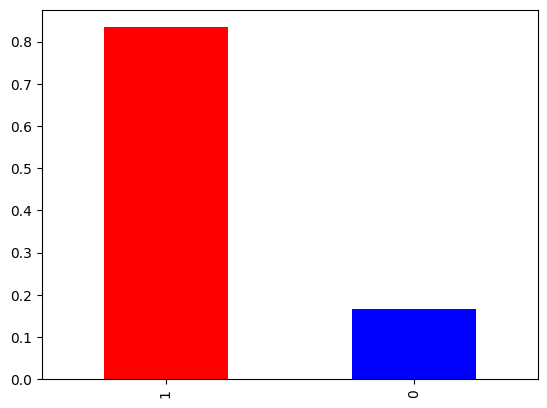

In [10]:
# Calculate positive and negative sample ratios
sizes = y_train.value_counts(normalize=True).plot(kind="bar", color=["red", "blue"])

### Correlation matrix

In [18]:
#Correlation matrix
corr_matrix = X_train.corr()

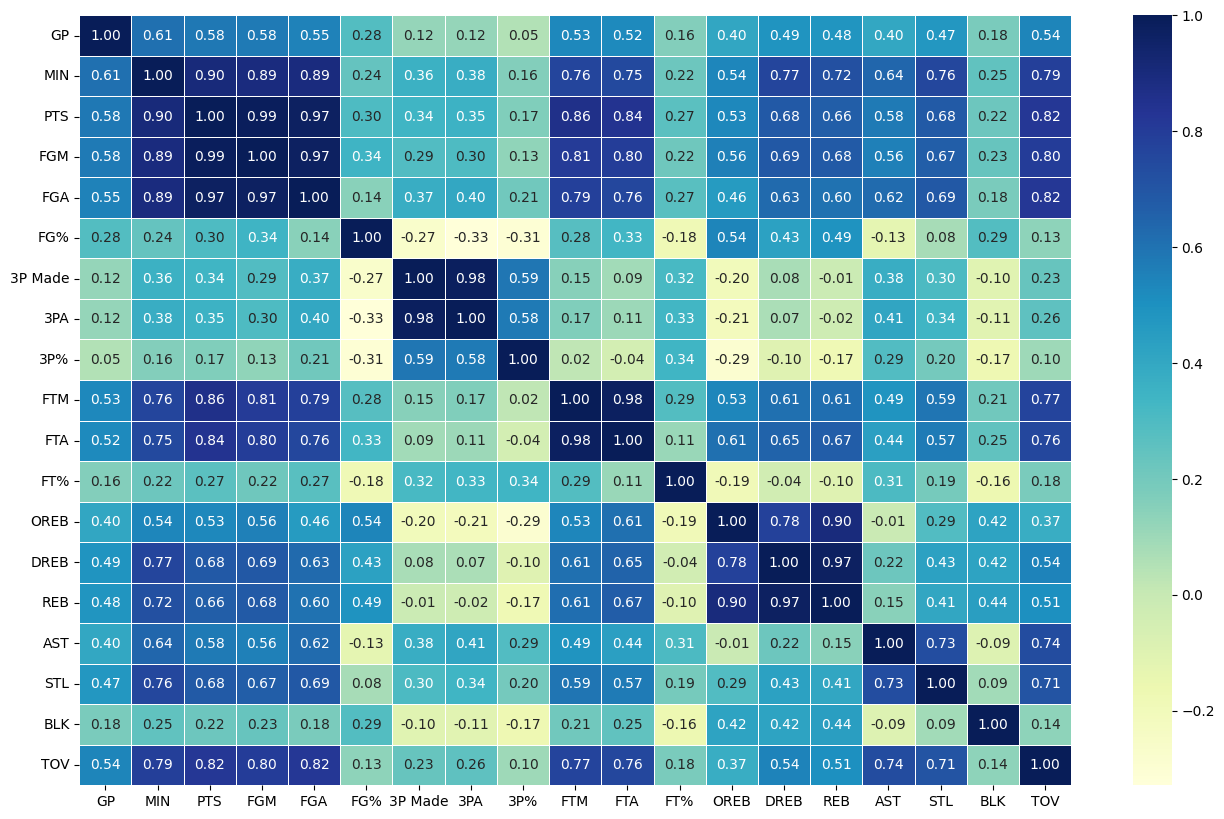

In [19]:
#plot heatmap
fig, ax = plt.subplots(figsize=(16,10))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap="YlGnBu")

## 3. Train model

In this experiment we will train logistic regression without feature engineering as baseline model

In [25]:
from src.trainers.LR import Trainer

trainer = Trainer()
model = trainer.train(X_train, y_train, model_filename='LR_base.joblib')

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/frodo/opt/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

## 4. Evaluation on test data

we applied the trained model on test data to obtain model performance 

In [28]:
evaluator = Evaluator()
accuracy, roc_auc = evaluator.evaluate(model, X_test, y_test)

print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.68      0.39       266
           1       0.91      0.63      0.75      1334

    accuracy                           0.64      1600
   macro avg       0.59      0.66      0.57      1600
weighted avg       0.80      0.64      0.69      1600

Confusion Matrix:
 [[181  85]
 [490 844]]
ROC AUC Score: 0.7048449459480786
Accuracy: 0.640625
ROC AUC: 0.7048449459480786


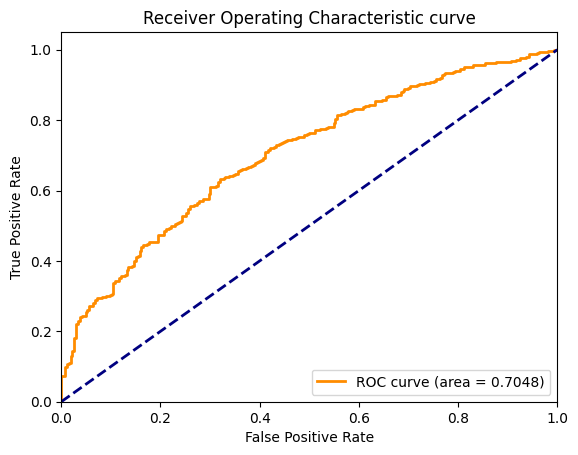

In [29]:
evaluator.plot_roc_curve(model, X_test, y_test)

## 5. Feature importance

In [30]:
feature_importance = model.best_estimator_.named_steps['classifier'].coef_
feature_names = X_train.columns.tolist()
result = dict(zip(feature_names, feature_importance[0]))

### Plot the feature importances

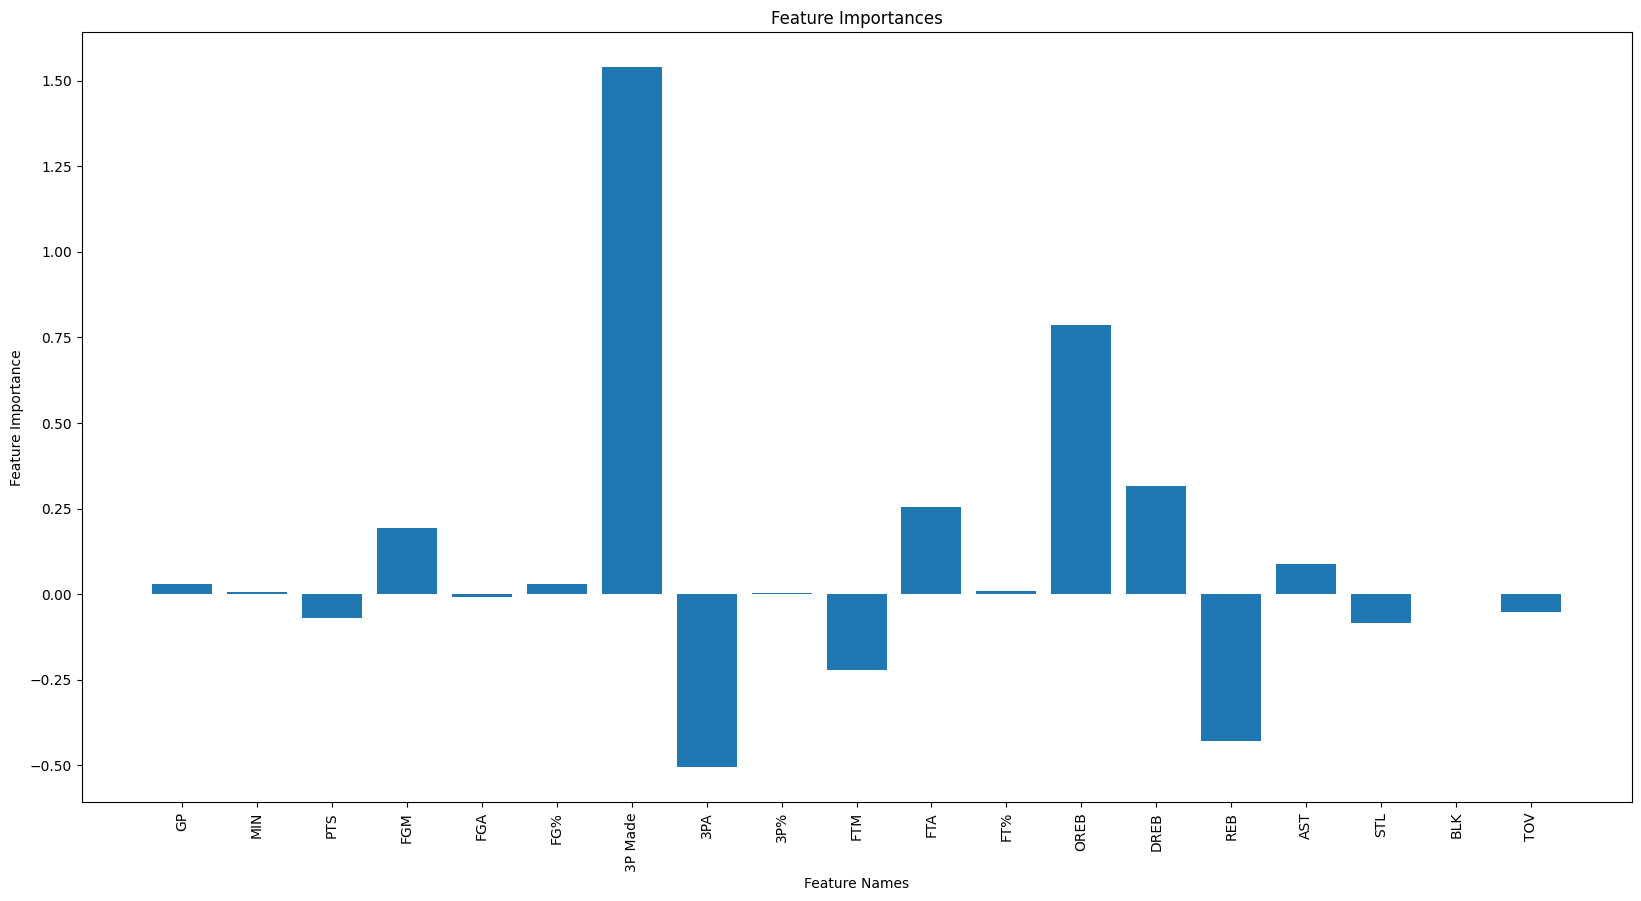

In [31]:
plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(feature_importance[0])), feature_importance[0], align='center')
plt.xticks(np.arange(len(feature_importance[0])), feature_names, rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

## 6. Prediction

Finally we applied the trained model on test data and upload our result to obtain score

### Load test data

In [32]:
#Load the dataset
df_test = pd.read_csv("data/raw/nba_test.csv")
df_test = df_test.set_index(['Id'])

### Load the model

In [35]:
import joblib

# Load the model from the file 
model = joblib.load('models/LR_base.joblib') 

### Obtain predict value

In [36]:
# prediction
y_label = model.predict(df_test)
y_score = model.predict_proba(df_test)[:, 1]

[CV] END classifier__C=0.001, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.001, classifier__penalty=l2, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   2.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.5s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=saga; total time=   2.6s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   1.2s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] E

[CV] END classifier__C=0.001, classifier__penalty=l1, classifier__solver=saga; total time=   2.2s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.6s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=saga; total time=   2.5s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   1.2s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   1.8s
[CV] END classi

[CV] END classifier__C=0.001, classifier__penalty=l1, classifier__solver=saga; total time=   2.2s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=saga; total time=   1.9s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   2.3s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=saga; total time=   2.5s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   1.1s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.0s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   1.8s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=saga; total time=   2.4s
[CV] END classifier__C=0.001, classifier__penalty=l1, classifier__solver=saga; total time=   2.4s
[CV] END classifier__C=0.1

## 7. Push changes

**[7.1]** Add the changes to git staging area

In [ ]:
git add .

**[7.2]** Create the snapshot of the repository and add a description

In [ ]:
git commit -m "Logistic Regression baseline"

**[7.3]** Push snapshot to Github

In [ ]:
git push

**[7.4]** Check out to the master branch

In [ ]:
git checkout main

**[7.5]** Pull the latest updates

In [ ]:
git pull

**[7.6]** Stop the Docker container

In [ ]:
docker stop adv_dsi_ass_1

## Reference

So, A. (2023). 36114_AdvDSI_Lab2_Exercise1_Solutions. https://drive.google.com/file/d/1qvDjDUmccLj8uPEiTA7vk0QK_QuR7tnu/view